# Discovery index calculation

1. Supplemental Figure 1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Upload sample names
path='/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/'
with open(os.path.join(path, 'discovery', 'samples.json'), 'rt') as g:
    samples = json.load(g)
    
# Upload mutations from the training cohorts
mutations = pd.read_csv(os.path.join(path, 'discovery', 'mutations.tsv'), sep='\t')
print(len(mutations))
mutations.columns

438010


Index(['sampleID', 'chr', 'pos', 'ref', 'mut', 'gene', 'strand', 'ref_cod',
       'mut_cod', 'ref3_cod', 'mut3_cod', 'aachange', 'ntchange', 'codonsub',
       'impact', 'pid', 'COHORT'],
      dtype='object')

## 1. Supplemental Figure 1

In [4]:
import sys

from functools import reduce
import operator
import random
import numpy as np
from scipy.optimize import minimize


def get_mutations(mutations, ttype, gene):

    df = mutations[mutations['gene'] == gene]
    df['chr'] = df['chr'].astype(str)
    df['pos'] = df['pos'].astype(int)
    return df


def get_downsampling_counts(samples_info, df_observed, iterations=10, n_grid=10):
    """
    :returns:
        grid: list of values, representing number of samples from which unique counts are drawn
        unique_counts: list of unique count set sizes for various replicates; each set has n=iterations elements
        the list has same length as n_grid
    """

    n = len(samples_info)
    grid = np.linspace(0, n, n_grid)
    unique_counts = []
    for value in grid:
        muts_list = []
        for _ in range(iterations):
            selected_samples = random.sample(samples_info, int(value))
            muts = df_observed[
                (df_observed['sampleID'].isin(selected_samples)) & (df_observed['impact'] != 'Synonymous')
            ][['chr', 'pos', 'mut']].drop_duplicates().shape[0]
            muts_list.append(muts)
        unique_counts.append(muts_list)
    return grid, unique_counts


def curve_fit(func, x_data, y_data, seed_params=None, weights=None, bounds=None):
    """custom curve fit function with a vector of weights"""

    if weights is None:
        weights = np.ones_like(x_data)
    assert(len(weights) == len(x_data))

    def cost(params):
        predictions = np.array([func(x, *params) for x in x_data])
        return np.dot(weights, (predictions - y_data) ** 2)

    res = minimize(cost, seed_params, bounds=bounds, options={'disp': False})
    return cost(res.x), res.x


def master_func(x, m, p):
    """
    master function to be fit
    refer to the Supplementary Note for a justification
    """
    return m * (1 - ((m - p) / m) ** x)


def discovery_index(total_samples, *params):
    """how far best fitting curve plateaus from current level unique mutations discovered"""

    m = params[0]
    a = master_func(total_samples, *params) / m
    return min(a, 1)


def bootstrap_data(unique_counts, iterations=10, ngrid=7):

    y_data_bootstrap = []
    for _ in range(iterations):
        y_sample = []
        for i in range(ngrid):
            r = np.random.choice(unique_counts[i], size=1)
            y_sample.append(r[0])
        y_data_bootstrap += [y_sample]
    return y_data_bootstrap


def fitting_with_bootstrap(grid, unique_counts, iterations=10, ngrid=7):

    params_pool = []
    y_data_bootstrap = bootstrap_data(unique_counts, iterations=iterations, ngrid=ngrid)

    # setting weights
    n = 2 * np.log10(ngrid)
    weights = 1 / (1 + np.std(y_data_bootstrap, axis=0) ** n)

    # setting optimization constraints
    bounds = [(unique_counts[-1][-1] / 2, None), (0, None)]

    for i, y in enumerate(y_data_bootstrap):
        error, params = curve_fit(master_func, grid, y,
                                  seed_params=[y[-1], 0.05],
                                  weights=weights,
                                  bounds=bounds)
        params_pool += [list(params)]

    total_samples = grid[-1]
    sat_list = [discovery_index(total_samples, *params) for params in params_pool]

    return params_pool, sat_list


def discovery_index_with_bootstrap(samples, mutations, iterations=10, ngrid=10):
    
    np.random.seed(42)
    random.seed(42)

    grid, unique_counts = get_downsampling_counts(samples, mutations,
                                                  iterations=iterations, n_grid=ngrid)
    params, disc_ind = fitting_with_bootstrap(grid, unique_counts, iterations=iterations, ngrid=ngrid)
    return params, disc_ind, grid, unique_counts


def discovery_run(samples, mutations, iterations=20, ngrid=20):
    """
    :return:
        no. samples
        no. total of unique mutations
        median discovery index
        interquartile range discovery index
    """

    params_list, disc_ind, grid, unique_counts = discovery_index_with_bootstrap(samples, mutations, iterations, ngrid)
    median = np.nanmedian(disc_ind)
    interquartile_range = (np.nanquantile(disc_ind, 0.25), np.nanquantile(disc_ind, 0.75))
    return grid[-1], unique_counts[-1][-1], median, interquartile_range


def plot_fit(gene, ttype, samples, mutations, ax, iterations=10, ngrid=20, color_scatter='grey', color_curve='darkred', ylabel=False):
    np.random.seed(42)
    random.seed(42)

    samp = samples[ttype]
    muts = get_mutations(mutations, ttype, gene)

    params, disc, grid, unique_counts = discovery_index_with_bootstrap(samp, muts, iterations, ngrid)

    unique_np = np.array(unique_counts)

    for i in range(iterations):
        if i == 0:
            ax.scatter(grid, unique_np[:, i], color=color_scatter, s=5, alpha=0.07)
        else:
            ax.scatter(grid, unique_np[:, i], color=color_scatter, s=5, alpha=0.07)

    x = np.linspace(0, grid[-1], num=50)
    y_mean = list(map(np.mean, zip(*map(lambda p: [master_func(s, *p) for s in x], params))))
    score = np.round(np.median(disc), 2)
    ax.plot(x, y_mean, alpha=1, color=color_curve, label=f'{gene}')

    ax.set_xlabel('no. samples')
    if ylabel:
        ax.set_ylabel('no. unique mutations')

    ax.text(s=f'discovery\nindex = {score}', y=1, x=10000, weight='bold')
    ax.set_title(f'{gene}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [5]:
# Individual panels

def plot_discovery_gene_ttype(gene, ttype):
    fig, ax = plt.subplots(figsize=(3, 3))
    plot_fit(gene, ttype, samples, mutations, ax, ylabel=True)
    plt.show()


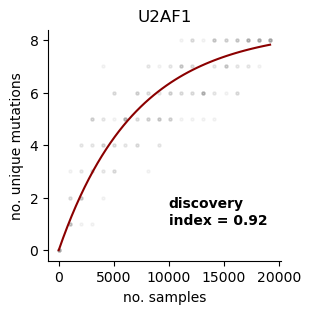

In [6]:
plot_discovery_gene_ttype('U2AF1', 'CH')

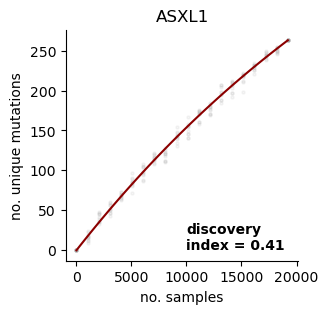

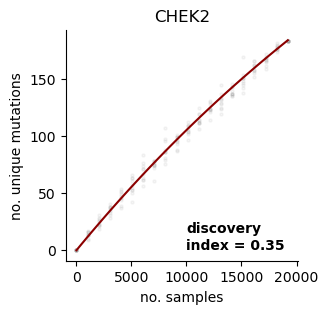

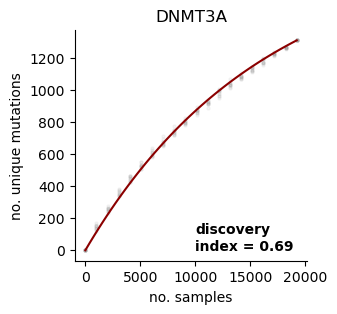

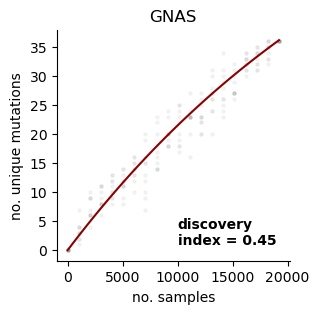

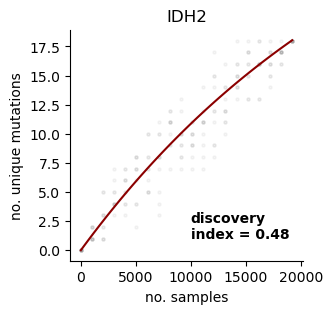

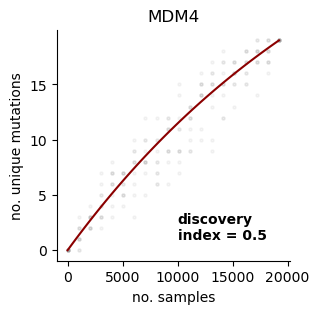

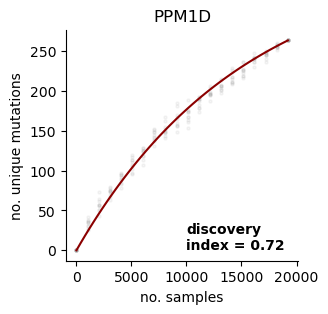

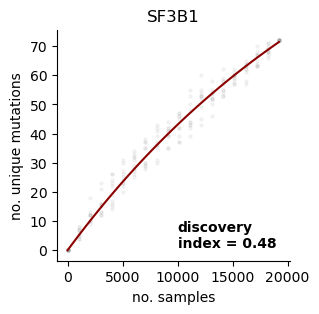

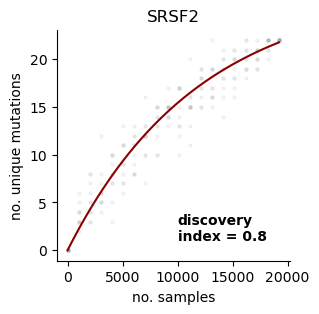

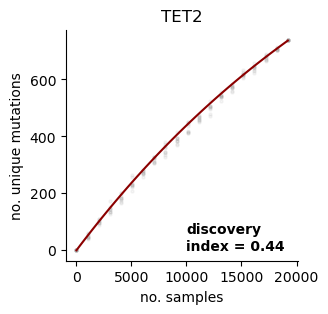

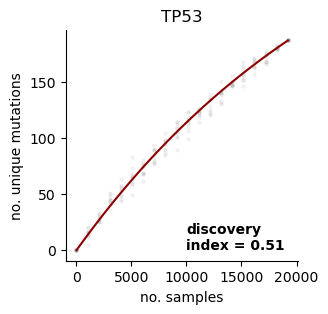

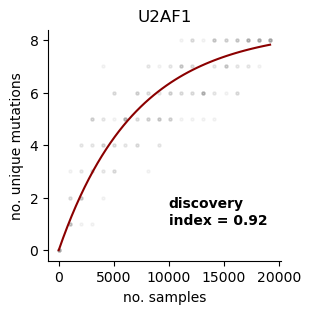

In [7]:
genes=['ASXL1', 'CHEK2', 'DNMT3A', 'GNAS', 'IDH2', 'MDM4', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']
for gene in genes:
    plot_discovery_gene_ttype(gene, 'CH')